<a href="https://colab.research.google.com/github/WestChaeVI/CNN-models/blob/main/models/DenseNet(64.45%25).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pwd

'/content'

In [3]:
%cd /content/drive/MyDrive/CV_seminar_project

/content/drive/MyDrive/CV_seminar_project


In [4]:
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim

# utils
import numpy as np
from torchsummary import summary

import torch
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu' # device 배정
torch.manual_seed(42)
if device == 'cuda':
  torch.cuda.manual_seed_all(42)
device

'cuda'

In [5]:
import torch.nn as nn

# 하이퍼파라미터
batch_size = 32
lr = 0.0001
epochs = 100
optimizer_name = 'adam'

model_name = 'DenseNet'
criterion = nn.CrossEntropyLoss().to(device) # cost function 패널티 주는 역할

root_path = '/content/drive/MyDrive/CV_seminar_project'
train_path = '/content/drive/MyDrive/CV_seminar_project/train'
valid_path = '/content/drive/MyDrive/CV_seminar_project/valid'

In [6]:
from cv_dataset import Custom_dataset as C
from torch.utils.data import Dataset, DataLoader
import cv2
import os
import torch
import torchvision
from torchvision import transforms # 이미지 데이터 augmentation
import os
import glob
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2 # albumentations 텐서화 함수

train_transforms = A.Compose([
    A.Resize(224,224), # 
    A.Transpose(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=20, val_shift_limit=20, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
    A.ChannelShuffle(),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0), # 이미지넷 데이터셋 통계값으로 Normalize
    A.CoarseDropout(p=0.5),
    ToTensorV2() # 텐서화만 적용 , pytorch albumentation의 totensor 는 min_max scaling 적용까지
])

test_transforms = A.Compose([
    A.Resize(224,224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0), # 텐서타입은 안해줌
    ToTensorV2() # Normalize를 먼저하고 tensor화를 진행해야한다.
])

### Pytorch 데이터 클래스 생성
train_class = C(root_path=root_path, mode='train', transforms=train_transforms)
valid_class = C(root_path=root_path, mode='valid', transforms=test_transforms)
test_class = C(root_path=root_path, mode='test', transforms=test_transforms)

### Pytorch BatchLoader 생성 (학습에 이용할 최종 dataloader)
from torch.utils.data import DataLoader as DataLoader

train_loader = DataLoader(train_class, batch_size=batch_size, shuffle = True, num_workers=0)
valid_loader = DataLoader(valid_class, batch_size=batch_size, shuffle = False, num_workers=0)
test_loader = DataLoader(test_class, batch_size=batch_size, shuffle = False, num_workers=0)

# Define DenseNet Architecture

In [7]:
# DenseNet BottleNeck
class BottleNeck(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super().__init__()
        inner_channels = 4 * growth_rate

        self.residual = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, inner_channels, 1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(inner_channels),
            nn.ReLU(),
            nn.Conv2d(inner_channels, growth_rate, 3, stride=1, padding=1, bias=False)
        )

        self.shortcut = nn.Sequential()

    def forward(self, x):
        return torch.cat([self.shortcut(x), self.residual(x)], 1)

In [8]:
# Transition Block: reduce feature map size and number of channels
class Transition(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.down_sample = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, out_channels, 1, stride=1, padding=0, bias=False),
            nn.AvgPool2d(2, stride=2)
        )

    def forward(self, x):
        return self.down_sample(x)

In [9]:
# DenseNet
class DenseNet(nn.Module):
    def __init__(self, nblocks, growth_rate=24, reduction=0.5, num_classes=3, init_weights=True):
        super().__init__()

        self.growth_rate = growth_rate
        inner_channels = 2 * growth_rate # output channels of conv1 before entering Dense Block

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, inner_channels, 7, stride=2, padding=3),
            nn.MaxPool2d(3, 2, padding=1)
        )

        self.features = nn.Sequential()

        for i in range(len(nblocks)-1):
            self.features.add_module('dense_block_{}'.format(i), self._make_dense_block(nblocks[i], inner_channels))
            inner_channels += growth_rate * nblocks[i]
            out_channels = int(reduction * inner_channels)
            self.features.add_module('transition_layer_{}'.format(i), Transition(inner_channels, out_channels))
            inner_channels = out_channels 
        
        self.features.add_module('dense_block_{}'.format(len(nblocks)-1), self._make_dense_block(nblocks[len(nblocks)-1], inner_channels))
        inner_channels += growth_rate * nblocks[len(nblocks)-1]
        self.features.add_module('bn', nn.BatchNorm2d(inner_channels))
        self.features.add_module('relu', nn.ReLU())

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.linear = nn.Linear(inner_channels, num_classes)

        # weight initialization
        if init_weights:
            self._initialize_weights()
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.features(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

    def _make_dense_block(self, nblock, inner_channels):
        dense_block = nn.Sequential()
        for i in range(nblock):
            dense_block.add_module('bottle_neck_layer_{}'.format(i), BottleNeck(inner_channels, self.growth_rate))
            inner_channels += self.growth_rate
        return dense_block

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def DenseNet_121():
    return DenseNet([6, 12, 24, 6])

In [10]:
# check model
x = torch.randn(32, 3, 224, 224)
model = DenseNet_121()
output = model(x)
print(output.size())

torch.Size([32, 3])


In [11]:
# print model summary
summary(model.to(device), (3, 224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 48, 112, 112]           7,104
         MaxPool2d-2           [-1, 48, 56, 56]               0
       BatchNorm2d-3           [-1, 48, 56, 56]              96
              ReLU-4           [-1, 48, 56, 56]               0
            Conv2d-5           [-1, 96, 56, 56]           4,608
       BatchNorm2d-6           [-1, 96, 56, 56]             192
              ReLU-7           [-1, 96, 56, 56]               0
            Conv2d-8           [-1, 24, 56, 56]          20,736
        BottleNeck-9           [-1, 72, 56, 56]               0
      BatchNorm2d-10           [-1, 72, 56, 56]             144
             ReLU-11           [-1, 72, 56, 56]               0
           Conv2d-12           [-1, 96, 56, 56]           6,912
      BatchNorm2d-13           [-1, 96, 56, 56]             192
             ReLU-14           [-1, 96,

# train

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = 1e-8) # 학습을 할수록 학습률 낮춰주는 역할(러닝 보폭 줄이기, 섬세하게 보기위해)

In [13]:
from tqdm import tqdm
from tensorflow import summary
from torch.utils.tensorboard import SummaryWriter
import argparse
import logging
from pathlib import Path
from torch import optim
import numpy as np

train_acc_lst, train_loss_lst, test_acc_lst, test_loss_lst= [], [], [], []

epochs = 200
model_name = 'DenseNet'
state={}

for epoch in range(1, epochs+1):

  train_loss = 0.0
  total = 0
  correct = 0
  train_acc = 0
  
  model.train()
  for i, (train_img, train_label) in enumerate(train_loader):
    # gpu에 할당
    train_img = train_img.to(device)
    train_label = train_label.to(device)

    output = model(train_img) # 모델에 입력

    optimizer.zero_grad( set_to_none = True ) # 계산했던 가중치 초기화    
    loss = criterion(output, train_label)
    loss.backward() # 미분
    optimizer.step() # 학습

    # loss & acc
    train_loss += loss.item()
    _, predictions = torch.max(output.data ,dim = 1)
   
    total += train_label.size(0)
    correct += (predictions == train_label).sum().item()
    train_acc += 100 * (correct / total)

  train_loss = round(train_loss/(i+1), 3) # 소수점 반올림
  train_acc = round(train_acc/(i+1), 3)
  print(f'Trainset {epoch}/{epochs} Loss : {train_loss}, Accuracy : {train_acc}%')
  train_acc_lst.append(train_acc)
  train_loss_lst.append(train_loss)

  # -------------------------------------------------------------------------------------
  test_loss = 0.0
  corrects = 0
  totals = 0
  test_acc = 0

  model.eval()
  with torch.no_grad():

    for i, (valid_img, valid_label) in enumerate(valid_loader):
          # gpu에 할당
      valid_img = valid_img.to(device)
      valid_label = valid_label.to(device)

      outputs = model(valid_img) # 모델에 입력
      losses = criterion(outputs, valid_label)

      # loss & acc
      test_loss += losses.item()
      _, predictions = torch.max(outputs.data ,dim = 1 )
    
      totals += valid_label.size(0)
      corrects += (predictions == valid_label).sum().item()
      test_acc += 100 * (corrects / totals)

    test_loss = round(test_loss/(i+1), 3) # 소수점 반올림
    test_acc = round(test_acc/(i+1), 3)
    print(f'Validset {epoch}/{epochs} Loss : {test_loss}, Accuracy : {test_acc}% \n')
    test_loss_lst.append(test_loss)
    test_acc_lst.append(test_acc)
  
  # 모델 저장
  if np.max(test_acc_lst) <= test_acc:

    state['epoch'] = epoch
    state['net'] = model.state_dict()

    state['train_loss'] = train_loss
    state['test_loss'] = test_loss

    state['train_acc'] = train_acc
    state['test_acc'] = test_acc
torch.save(state, '/content/drive/MyDrive/CNN models/SENet_{}_{}.pth'.format(str(state['epoch']), str(state['test_acc'])))

Trainset 1/200 Loss : 1.08, Accuracy : 35.257%
Validset 1/200 Loss : 1.024, Accuracy : 41.064% 

Trainset 2/200 Loss : 1.067, Accuracy : 43.706%
Validset 2/200 Loss : 1.008, Accuracy : 33.742% 

Trainset 3/200 Loss : 1.062, Accuracy : 42.377%
Validset 3/200 Loss : 0.996, Accuracy : 46.352% 

Trainset 4/200 Loss : 1.046, Accuracy : 46.835%
Validset 4/200 Loss : 0.987, Accuracy : 45.517% 

Trainset 5/200 Loss : 1.047, Accuracy : 45.699%
Validset 5/200 Loss : 0.985, Accuracy : 43.529% 

Trainset 6/200 Loss : 1.05, Accuracy : 47.825%
Validset 6/200 Loss : 0.995, Accuracy : 42.011% 

Trainset 7/200 Loss : 1.049, Accuracy : 43.532%
Validset 7/200 Loss : 1.006, Accuracy : 39.35% 

Trainset 8/200 Loss : 1.052, Accuracy : 46.465%
Validset 8/200 Loss : 0.979, Accuracy : 39.363% 

Trainset 9/200 Loss : 1.029, Accuracy : 48.096%
Validset 9/200 Loss : 0.967, Accuracy : 41.439% 

Trainset 10/200 Loss : 1.048, Accuracy : 42.285%
Validset 10/200 Loss : 0.999, Accuracy : 43.827% 

Trainset 11/200 Loss 

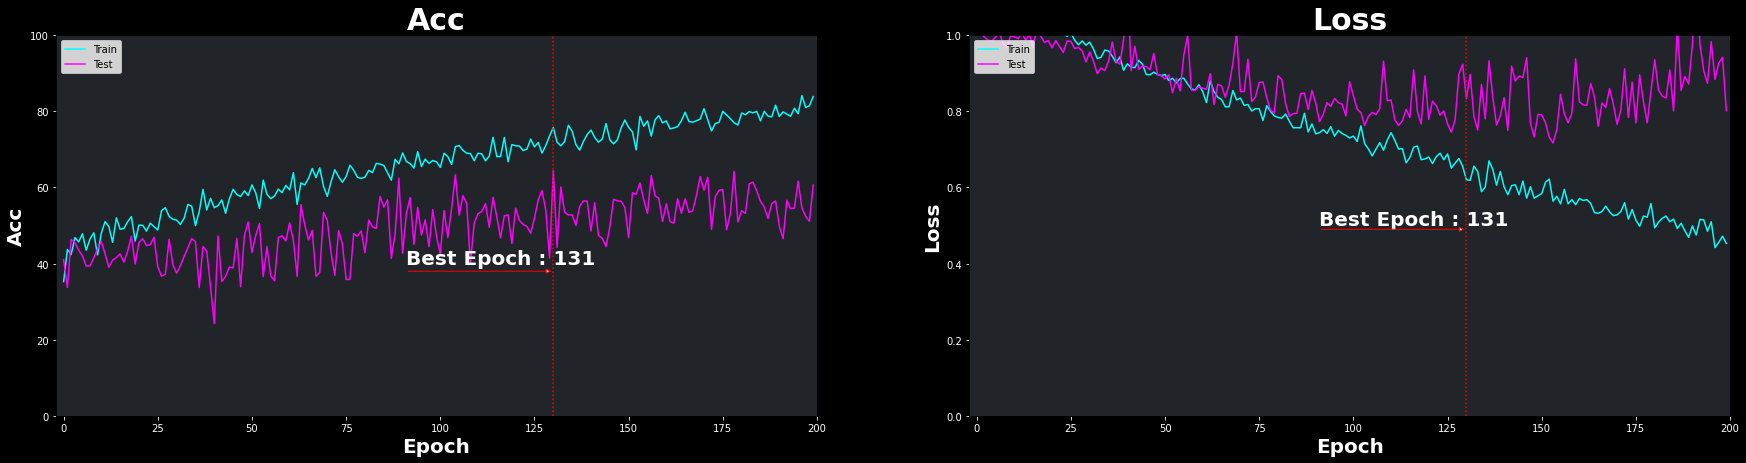

In [14]:
import matplotlib.pyplot as plt
import numpy as np

arrowprops = dict(fc='white', color='red',arrowstyle="-|>")
font1 = {'family': 'serif',
    'color':  'darkred',
    'weight': 'normal',
    'size': 16}
  

fig = plt.figure(figsize=(30,7),facecolor='black')
plt = fig.subplots(1,2)

train_score = {'Acc':train_acc_lst, 'Loss':train_loss_lst}
valid_score = {'Acc':test_acc_lst, 'Loss':test_loss_lst}

for i in range(len(train_score.keys())):
  plt[i].plot(train_score[list(train_score.keys())[i]], c='cyan')
  plt[i].plot(valid_score[list(valid_score.keys())[i]],c='magenta')
  plt[i].set_title(list(valid_score.keys())[i],color='white', fontweight='bold', fontsize=30)
  plt[i].set_ylabel(list(valid_score.keys())[i],color='white', fontweight='bold', fontsize=20)
  plt[i].set_xlabel('Epoch',color='white', fontweight='bold', fontsize=20)
  if i == 0:
    plt[i].set_ylim([0,100])
    plt[i].text(state['epoch']-40,40, "Best Epoch : {}".format(state['epoch']), 
            fontdict= {'color':  'white','weight': 'bold','size': 20})
    plt[i].annotate("",xy=(state['epoch']-1, 38),
                xytext=(state['epoch']-40,38),
                arrowprops=arrowprops)
  else:
    plt[i].set_ylim([0,1])
    plt[i].text(state['epoch']-40,0.5, "Best Epoch : {}".format(state['epoch']), 
            fontdict= {'color':  'white','weight': 'bold','size': 20})
    plt[i].annotate("",xy=(state['epoch']-1, 0.49),
                xytext=(state['epoch']-40,0.49),
                arrowprops=arrowprops)

  plt[i].set_xlim([-2, 200])
  plt[i].legend(['Train', 'Test'], loc='upper left')
  plt[i].axvline(x=state['epoch']-1, color='r', linestyle=':')
  plt[i].tick_params(axis='x', colors='white')
  plt[i].tick_params(axis='y', colors='white')
  plt[i].patch.set_facecolor('#212529')




In [15]:
print('200 epcohs 중 validset 기준 accuracy {} % 성능을 달성하였습니다.'.format(max(test_acc_lst)))

200 epcohs 중 validset 기준 accuracy 64.452 % 성능을 달성하였습니다.
